## Imports for PC-HMM

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
import random

%matplotlib inline

## Imports for GRU-D

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_SRC_DIR = "/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV"
sys.path.append(os.path.join(PROJECT_SRC_DIR, "GRU_D", "GRU-D"))
from models import create_grud_model
import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
import random
%matplotlib inline

## Import for MixMatch and FixMatch

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import sys
import torch

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
import random

PROJECT_SRC_DIR = "/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV"
sys.path.append(os.path.join(PROJECT_SRC_DIR, "MixMatch"))
from SimpleRNN import SimpleRNN

import torch.utils.data as data
%matplotlib inline

In [4]:
## DO NOT DELETE. Needed to run the following cells
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/mortality_prediction/'

## Get performance of PC-HMM classification as a function of % labelled sequences

In [5]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
random_seed_list = [42, 1783, 78970, 86787, 8675309, 241, 61, 8942, 23, 555]



pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(x_test.shape[0]), int(0.9*x_test.shape[0])) 
        curr_y_test = y_test[rnd_inds]
        curr_x_test = x_test[rnd_inds, :]
        curr_y_pred_proba = y_test_pred_proba[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    
    pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                 'test_AUC' : test_roc_auc,
                 'test_AUPRC' : test_auprc,
                 'test_AUPRC_50' : np.median(auprc_np),
                 'test_AUPRC_5' : np.percentile(auprc_np, 5),
                 'test_AUPRC_95' : np.percentile(auprc_np, 95)})
    
    
    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

pchmm_perf_df = pd.DataFrame(pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=120-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=10-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.196
test AUPRC (bootstrapped test): 0.196
test AUROC (full test): 0.688
test AUROC (bootstrapped test): 0.685
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=891-init_strategy=kmeans-batch_size=256-perc_labelled=3.7-predictor_l2_penalty=0.1-n_states=20-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.229
test AUPRC (bootstrapped test): 0.229
test AUROC (full test): 0.731
test AUROC (bootstrapped test): 0.729
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=5-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=50-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.295
test AUPRC (bootstrapped test): 0.292
test AUROC (full test): 0.784
test AUROC (bootstrapped test): 0.783
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=120-init_strategy=kmeans-batch_size=128-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.328
test AUPRC (bootstrapped test): 0.326
test AUROC (full test): 0.814
test AUROC (bootstrapped test): 0.814
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=123819-init_strategy=kmeans-batch_size=128-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.342
test AUPRC (bootstrapped test): 0.341
test AUROC (full test): 0.826
test AUROC (bootstrapped test): 0.826


In [3]:
pchmm_perf_df

NameError: name 'pchmm_perf_df' is not defined

## Get performance of HMM + predictor trained separately

In [6]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/mortality_prediction/'
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']


hmm_plus_pred_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s-*lamb=0*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])
    
    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(x_test.shape[0]), int(0.9*x_test.shape[0])) 
        curr_y_test = y_test[rnd_inds]
        curr_x_test = x_test[rnd_inds, :]
        curr_y_pred_proba = y_test_pred_proba[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    
    
    hmm_plus_pred_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : np.median(auprc_np),
                     'test_AUPRC_5' : np.percentile(auprc_np, 5),
                     'test_AUPRC_95' : np.percentile(auprc_np, 95)})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

hmm_plus_pred_perf_df = pd.DataFrame(hmm_plus_pred_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=0-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.190
test AUPRC (bootstrapped test): 0.189
test AUROC (full test): 0.652
test AUROC (bootstrapped test): 0.653
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0.1-n_states=5-lamb=0-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.208
test AUPRC (bootstrapped test): 0.208
test AUROC (full test): 0.692
test AUROC (bootstrapped test): 0.693
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=11.1-predictor_l2_penalty=0.1-n_states=5-lamb=0-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.214
test AUPRC (bootstrapped test): 0.213
test AUROC (full test): 0.698
test AUROC (bootstrapped test): 0.697
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=0-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.204
test AUPRC (bootstrapped test): 0.205
test AUROC (full test): 0.684
test AUROC (bootstrapped test): 0.683
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=100-predictor_l2_penalty=0.1-n_states=5-lamb=0-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.212
test AUPRC (bootstrapped test): 0.212
test AUROC (full test): 0.698
test AUROC (bootstrapped test): 0.696


## Get performance of HMM + predictor trained with max likelihood (lambda=1)

In [7]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/mortality_prediction/'
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']


supervised_pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s-*lamb=1.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])
    
    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(x_test.shape[0]), int(0.9*x_test.shape[0])) 
        curr_y_test = y_test[rnd_inds]
        curr_x_test = x_test[rnd_inds, :]
        curr_y_pred_proba = y_test_pred_proba[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    
    supervised_pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : np.median(auprc_np),
                     'test_AUPRC_5' : np.percentile(auprc_np, 5),
                     'test_AUPRC_95' : np.percentile(auprc_np, 95)})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

supervised_pchmm_pred_perf_df = pd.DataFrame(supervised_pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=12-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.191
test AUPRC (bootstrapped test): 0.192
test AUROC (full test): 0.646
test AUROC (bootstrapped test): 0.646
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=12-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.207
test AUPRC (bootstrapped test): 0.206
test AUROC (full test): 0.695
test AUROC (bootstrapped test): 0.694
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=12-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.218
test AUPRC (bootstrapped test): 0.218
test AUROC (full test): 0.700
test AUROC (bootstrapped test): 0.699
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.266
test AUPRC (bootstrapped test): 0.264
test AUROC (full test): 0.741
test AUROC (bootstrapped test): 0.740
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.298
test AUPRC (bootstrapped test): 0.298
test AUROC (full test): 0.786
test AUROC (bootstrapped test): 0.786


## Get performance of GRU-D classification as a function of % labelled sequences

In [8]:
def get_train_test_data(CLF_TRAIN_TEST_SPLIT_PATH):
    x_train_np_filename = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_train.npy')
    x_test_np_filename = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_train_np_filename = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_train.npy')
    y_test_np_filename = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')    
    
    
    X_train_fs = np.load(x_train_np_filename)
    X_test = np.load(x_test_np_filename)
    y_train = np.load(y_train_np_filename)
    y_test = np.load(y_test_np_filename)
    
    return X_train_fs, y_train, X_test, y_test

In [5]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_perf_dict_list = []


X_train_fs, y_train, X_test, y_test = get_train_test_data(CLF_TRAIN_TEST_SPLIT_PATH)
X_train = X_train_fs.copy()
N,T,D = X_test.shape
just_T_hrs = np.arange(0, T)
train_x_mask_NTD = 1-np.isnan(X_train).astype(int)
test_x_mask_NTD = 1-np.isnan(X_test).astype(int)
test_timestep = np.expand_dims(just_T_hrs * np.ones(X_test.shape[:-1]), -1)


for d in range(D):
    # impute missing values by mean filling using estimates from full training set
    fill_vals = np.nanmean(X_train_fs[:, :, d])

    X_train[:, :, d] = np.nan_to_num(X_train[:, :, d], nan=fill_vals)
    X_test[:, :, d] = np.nan_to_num(X_test[:, :, d], nan=fill_vals)        

    # zscore normalization
    den = 1#np.nanstd(X_train_fs[:, :, d])
    X_train[:, :, d] = (X_train[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den
    X_test[:, :, d] = (X_test[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den   


for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/GRUD/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]
    
    input_dim = D
    output_dim = 1
    output_activation = 'sigmoid'
    predefined_model = 'GRUD'
    use_bidirectional_rnn=False
    outcome="did_overheat_binary_label"
    recurrent_dim = [128]
    hidden_dim = [8]

    model = create_grud_model(input_dim=input_dim,
                              output_dim=output_dim,
                              output_activation=output_activation,
                              recurrent_dim=recurrent_dim,
                              hidden_dim=hidden_dim,
                              predefined_model=predefined_model,
                              use_bidirectional_rnn=use_bidirectional_rnn)
    
    
    best_model_file = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')
    model.load_weights(best_model_file)
    
    
    test_roc_auc = perf_df['test_AUC']
    test_auprc = perf_df['test_AUPRC']

    # bootstrap of test set
    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    outputs = model.predict([X_test, test_x_mask_NTD, test_timestep])
    targets = y_test.copy()
    
    
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(targets.shape[0]), int(0.9*targets.shape[0])) 
        curr_y_test = targets[rnd_inds]
        curr_y_pred = np.argmax(outputs[rnd_inds], -1)
        curr_y_pred_proba = outputs[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test, curr_y_pred_proba)
    
    
    grud_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : np.median(auprc_np),
                     'test_AUPRC_5' : np.percentile(auprc_np, 5),
                     'test_AUPRC_95' : np.percentile(auprc_np, 95)}
                              )



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

grud_perf_df = pd.DataFrame(grud_perf_dict_list)
grud_perf_df.to_csv('grud_performance_mortality_prediction.csv', 
                    index=False)

In [8]:
# Use if you haven't run the GRU-D results due to different environment
grud_perf_df = pd.read_csv('grud_performance_mortality_prediction.csv')
grud_perf_df['test_AUPRC'] = [i.replace('0    ', '').replace('\nName: test_AUPRC, dtype: float64', '') for i in grud_perf_df['test_AUPRC'].values]
grud_perf_df['test_AUPRC'] = grud_perf_df['test_AUPRC'].astype(float)

## Get the MixMatch Performance as a function of % labelled sequences

In [9]:
def create_model(ema=False, hidden_size=64):
    model=SimpleRNN(input_size=D, hidden_size=hidden_size, 
                output_size=2, num_layers=2)
    return model

def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

In [10]:
mixmatch_perf_dict_list = []
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']

'''
X_train_fs, y_train, X_test, y_test = get_train_test_data(CLF_TRAIN_TEST_SPLIT_PATH)
N,T,D = X_test.shape    
X_train = X_train_fs.copy()
for d in range(D):
    # impute missing values by mean filling using estimates from full training set
    fill_vals = np.nanmean(X_train_fs[:, :, d])      
    
    X_train[:, :, d] = ffill(X_train[:, :, d])
    X_test[:, :, d] = ffill(X_test[:, :, d])
    
    X_train[:, :, d] = np.nan_to_num(X_train[:, :, d], nan=fill_vals)
    X_test[:, :, d] = np.nan_to_num(X_test[:, :, d], nan=fill_vals)
    
    
    # zscore normalization
    den = 1#np.nanstd(X_train_fs[:, :, d])
    X_train[:, :, d] = (X_train[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den
    X_test[:, :, d] = (X_test[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den  
    
    
test_data, test_label = torch.Tensor(X_test), torch.Tensor(y_test[:, np.newaxis])
test_set = data.TensorDataset(test_data, test_label)  
test_loader = data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=0)    
'''
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/MixMatch/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]
    '''
    best_model_file = best_model_perf_csv.replace('.csv', '.pt').replace('final_perf_', '')
    model = create_model()
    model.load_state_dict(torch.load(best_model_file))
    
    with torch.no_grad():      
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            batch_size = inputs.size(0)
            # Transform label to one-hot
            targets = torch.zeros(batch_size, 2).scatter_(1, targets.view(-1,1).long(), 1)            
#             test_auroc = roc_auc_score(targets, outputs)
#             test_auprc = average_precision_score(targets[:, 1], outputs[:, 1])
    
    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(targets.shape[0]), int(0.9*targets.shape[0])) 
        curr_y_test = targets[rnd_inds]
        curr_y_pred_proba = outputs[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    '''
    test_roc_auc = perf_df['test_AUROC'].values[-1]
    test_auprc = perf_df['test_AUPRC'].values[-1]

    '''
    mixmatch_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : np.median(auprc_np),
                     'test_AUPRC_5' : np.percentile(auprc_np, 5),
                     'test_AUPRC_95' : np.percentile(auprc_np, 95)})
    '''
    mixmatch_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : test_auprc,
                     'test_AUPRC_5' : test_auprc,
                     'test_AUPRC_95' : test_auprc})
    


    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%test_auprc)
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%test_roc_auc)
    print('=====================================================================================')

mixmatch_perf_df = pd.DataFrame(mixmatch_perf_dict_list)

================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.130
test AUPRC (bootstrapped test): 0.130
test AUROC (full test): 0.573
test AUROC (bootstrapped test): 0.573
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.150
test AUPRC (bootstrapped test): 0.150
test AUROC (full test): 0.599
test AUROC (bootstrapped test): 0.599
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.202
test AUPRC (bootstrapped test): 0.202
test AUROC (full test): 0.670
test AUROC (bootstrapped test): 0.670
================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.234
test AUPRC (bootstrapped test): 0.234
test AUROC (full test): 0.727
test AUROC (bootstrapped test): 0.727
================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.246
test AUPR

In [17]:
mixmatch_perf_df

,perc_labelled,test_AUC,test_AUPRC,test_AUPRC_50,test_AUPRC_5,test_AUPRC_95
0,1.2,0.573108,0.130467,0.132022,0.129104,0.135368
1,3.7,0.598663,0.150465,0.150404,0.145403,0.155268
2,11.1,0.670152,0.201557,0.179176,0.172571,0.186428
3,33.3,0.726873,0.234349,0.212348,0.207887,0.220222
4,100,0.743481,0.246231,0.212151,0.207278,0.218206


## Get FixMatch performance as a function of % labelled sequences

In [11]:
fixmatch_perf_dict_list = []
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']

'''
X_train_fs, y_train, X_test, y_test = get_train_test_data(CLF_TRAIN_TEST_SPLIT_PATH)
N,T,D = X_test.shape    
X_train = X_train_fs.copy()
for d in range(D):
    # impute missing values by mean filling using estimates from full training set
    fill_vals = np.nanmean(X_train_fs[:, :, d])      
    
#     X_train[:, :, d] = ffill(X_train[:, :, d])
#     X_test[:, :, d] = ffill(X_test[:, :, d])
    
    X_train[:, :, d] = np.nan_to_num(X_train[:, :, d], nan=fill_vals)
    X_test[:, :, d] = np.nan_to_num(X_test[:, :, d], nan=fill_vals)
    
    
    # zscore normalization
#     den = np.nanstd(X_train_fs[:, :, d])
#     if den==0:
    den=1
    
    X_train[:, :, d] = (X_train[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den
    X_test[:, :, d] = (X_test[:, :, d] - np.nanmean(X_train_fs[:, :, d]))/den  
    
    
test_data, test_label = torch.Tensor(X_test), torch.Tensor(y_test[:, np.newaxis])
test_set = data.TensorDataset(test_data, test_label)  
test_loader = data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=0)    
'''

for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/FixMatch/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]
    
    best_model_file = best_model_perf_csv.replace('.csv', '.pt').replace('final_perf_', '')
    '''
    model = create_model()
    model.load_state_dict(torch.load(best_model_file))
    
    with torch.no_grad():      
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            batch_size = inputs.size(0)
            # Transform label to one-hot
            targets = torch.zeros(batch_size, 2).scatter_(1, targets.view(-1,1).long(), 1)            
#             test_auroc = roc_auc_score(targets, outputs)
#             test_auprc = average_precision_score(targets[:, 1], outputs[:, 1])
    
    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(targets.shape[0]), int(0.9*targets.shape[0])) 
        curr_y_test = targets[rnd_inds]
        curr_y_pred_proba = outputs[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    '''
    test_roc_auc = perf_df['test_AUROC'].values[-1]
    test_auprc = perf_df['test_AUPRC'].values[-1]


    fixmatch_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : test_auprc,
                     'test_AUPRC_5' : test_auprc,
                     'test_AUPRC_95' : test_auprc})


    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%test_auprc)
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%test_roc_auc)
    print('=====================================================================================')

fixmatch_perf_df = pd.DataFrame(fixmatch_perf_dict_list)

================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.154
test AUPRC (bootstrapped test): 0.154
test AUROC (full test): 0.540
test AUROC (bootstrapped test): 0.540
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.177
test AUPRC (bootstrapped test): 0.177
test AUROC (full test): 0.633
test AUROC (bootstrapped test): 0.633
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.135
test AUPRC (bootstrapped test): 0.135
test AUROC (full test): 0.650
test AUROC (bootstrapped test): 0.650
================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.205
test AUPRC (bootstrapped test): 0.205
test AUROC (full test): 0.720
test AUROC (bootstrapped test): 0.720
================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.300
test AUPR

## Get BRITS performance as a function of % labelled sequences

In [12]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_perf_dict_list = []

for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/BRITS/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['AUPRC_valid'].values[-1]
        test_auprc_np[ii] = curr_perf_df['AUPRC_test'].values[-1]

    # curr_perf_df
    try:
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        print(perf_csvs[best_ind])
        test_roc_auc = perf_df['AUC_test'].values[-1]
        test_auprc = perf_df['AUPRC_test'].values[-1]
    except:
        test_roc_auc=np.nan
        test_auprc=np.nan


    brits_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc,
                     'test_AUPRC_50' : test_auprc,
                     'test_AUPRC_5' : test_auprc,
                     'test_AUPRC_95' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%test_auprc)
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%test_roc_auc)
    print('=====================================================================================')

brits_perf_df = pd.DataFrame(brits_perf_dict_list)

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=6504-batch_size=128-perc_labelled=1.2.csv
================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.145
test AUPRC (bootstrapped test): 0.145
test AUROC (full test): 0.628
test AUROC (bootstrapped test): 0.628
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=2414-batch_size=128-perc_labelled=3.7.csv
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.133
test AUPRC (bootstrapped test): 0.133
test AUROC (full test): 0.616
test AUROC (bootstrapped test): 0.616
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=6504-batch_size=128-perc_

## Plot  binary classification SSL performance 

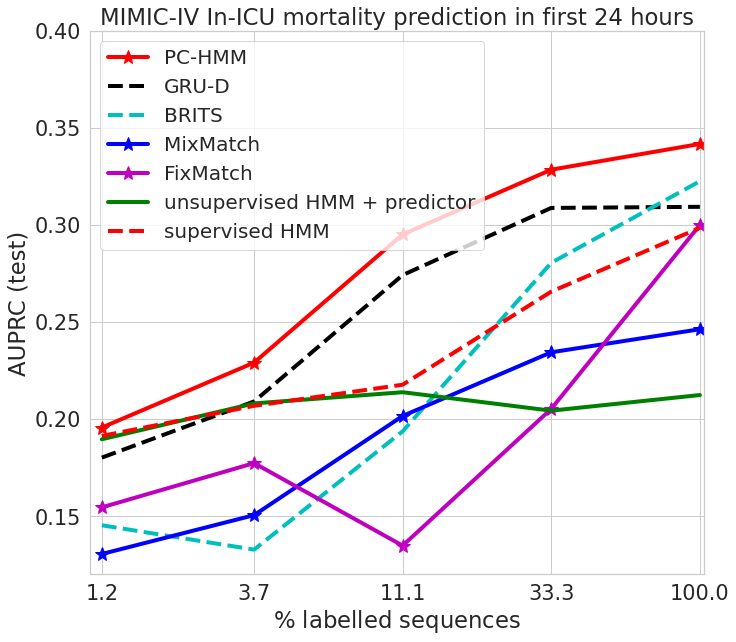

In [14]:
pchmm_perf_df['perc_labelled'] = pchmm_perf_df['perc_labelled'].astype(float)
grud_perf_df['perc_labelled'] = grud_perf_df['perc_labelled'].astype(float)
mixmatch_perf_df['perc_labelled'] = mixmatch_perf_df['perc_labelled'].astype(float)
fixmatch_perf_df['perc_labelled'] = fixmatch_perf_df['perc_labelled'].astype(float)
brits_perf_df['perc_labelled'] = brits_perf_df['perc_labelled'].astype(float)
hmm_plus_pred_perf_df['perc_labelled'] = hmm_plus_pred_perf_df['perc_labelled'].astype(float)
supervised_pchmm_pred_perf_df['perc_labelled'] = supervised_pchmm_pred_perf_df['perc_labelled'].astype(float)

ylims_list = [None,
             None,
             [0.08, 0.3]] 

f, axs = plt.subplots(1, 1, figsize=(11, 10))
sns.set_context('notebook', font_scale=1.9)
sns.set_style('whitegrid')
curr_pchmm_perf_df = pchmm_perf_df.sort_values(by='perc_labelled')
curr_grud_perf_df = grud_perf_df.sort_values(by='perc_labelled')
curr_mixmatch_perf_df = mixmatch_perf_df.sort_values(by='perc_labelled')
curr_fixmatch_perf_df = fixmatch_perf_df.sort_values(by='perc_labelled')
curr_brits_perf_df = brits_perf_df.sort_values(by='perc_labelled')
curr_hmm_plus_pred_perf_df = hmm_plus_pred_perf_df.sort_values(by='perc_labelled')
curr_supervised_hmm_pred_perf_df = supervised_pchmm_pred_perf_df.sort_values(by='perc_labelled')

perc_labelled = curr_pchmm_perf_df['perc_labelled'].values
test_auprc_pchmm_np = curr_pchmm_perf_df['test_AUPRC'].values
test_auprc_grud = curr_grud_perf_df['test_AUPRC'].values
test_auprc_mixmatch = curr_mixmatch_perf_df['test_AUPRC'].values
test_auprc_fixmatch = curr_fixmatch_perf_df['test_AUPRC'].values
test_auprc_brits = curr_brits_perf_df['test_AUPRC'].values
test_auprc_hmm_plus_pred = curr_hmm_plus_pred_perf_df['test_AUPRC'].values
test_auprc_supervised_hmm = curr_supervised_hmm_pred_perf_df['test_AUPRC'].values

lw=4
axs.plot(perc_labelled, test_auprc_pchmm_np, 'r*-', linewidth=lw, markersize=15, label='PC-HMM')
axs.plot(perc_labelled, test_auprc_grud, 'k--', linewidth=lw, label='GRU-D')
axs.plot(perc_labelled, test_auprc_brits, 'c--', linewidth=lw, label='BRITS')
axs.plot(perc_labelled, test_auprc_mixmatch, 'b*-', linewidth=lw, markersize=15, label='MixMatch')
axs.plot(perc_labelled, test_auprc_fixmatch, 'm*-', linewidth=lw, markersize=15, label='FixMatch')
axs.plot(perc_labelled, test_auprc_hmm_plus_pred, 'g-', linewidth=lw, label='unsupervised HMM + predictor')
axs.plot(perc_labelled, test_auprc_supervised_hmm, 'r--', linewidth=lw, label='supervised HMM')


#     axs.legend(bbox_to_anchor=(0.99, 1.05))
axs.set_title('MIMIC-IV In-ICU mortality prediction in first 24 hours')

axs.set_xscale('log')    
axs.set_xticks(perc_labelled)
axs.set_xticklabels(perc_labelled)

axs.set_xlim([1.1, 103])
# if ylims_list[pp] is not None:
#     axs.set_ylim(ylims_list[pp])
axs.set_ylabel('AUPRC (test)')
axs.set_xlabel(r'$\%$ labelled sequences')
axs.set_ylim([0.12, 0.4])

axs.legend(
#             bbox_to_anchor=(0.99, 1.05),
loc='upper left', fontsize=20
)
    
f.savefig('perf_mortality_prediction_mimic.pdf',
          bbox_inches='tight')
f.savefig('perf_mortality_prediction_mimic.png',
          bbox_inches='tight')

# f.savefig('perf_mortality_prediction_mimic_nothing.png',
#           bbox_inches='tight')
    

In [26]:
test_auprc_grud


array(['0.180109', '0.20905', '0.274126', '0.308715', '0.30929'],
      dtype=object)

In [40]:
legend.legendHandles

## Get PC-HMM performance with max-pooling across time

In [3]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
random_seed_list = [42, 1783, 78970, 86787, 8675309, 241, 61, 8942, 23, 555]



max_pool_pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/max_pooling/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))
    
    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(x_test.shape[0]), int(0.9*x_test.shape[0])) 
        curr_y_test = y_test[rnd_inds]
        curr_x_test = x_test[rnd_inds, :]
        curr_y_pred_proba = y_test_pred_proba[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    
    max_pool_pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                 'test_AUC' : test_roc_auc,
                 'test_AUPRC' : test_auprc,
                 'test_AUPRC_50' : np.median(auprc_np),
                 'test_AUPRC_5' : np.percentile(auprc_np, 5),
                 'test_AUPRC_95' : np.percentile(auprc_np, 95)})
    
    
    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

max_pool_pchmm_perf_df = pd.DataFrame(max_pool_pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/max_pooling/semi-supervised-pchmm-lr=0.005-seed=555-init_strategy=kmeans-batch_size=256-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=1000-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.138
test AUPRC (bootstrapped test): 0.138
test AUROC (full test): 0.672
test AUROC (bootstrapped test): 0.673
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/max_pooling/semi-supervised-pchmm-lr=0.005-seed=555-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.197
test AUPRC (bootstrapped test): 0.196
test AUROC (full test): 0.737
test AUROC (bootstrapped test): 0.736
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/max_pooling/semi-supervised-pchmm-lr=0.005-seed=555-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.274
test AUPRC (bootstrapped test): 0.272
test AUROC (full test): 0.752
test AUROC (bootstrapped test): 0.752
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/max_pooling/semi-supervised-pchmm-lr=0.005-seed=661-init_strategy=kmeans-batch_size=128-perc_labelled=33.3-predictor_l2_penalty=0.1-n_states=5-lamb=1000-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.258
test AUPRC (bootstrapped test): 0.258
test AUROC (full test): 0.782
test AUROC (bootstrapped test): 0.782
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/max_pooling/semi-supervised-pchmm-lr=0.005-seed=421-init_strategy=kmeans-batch_size=128-perc_labelled=100-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.281
test AUPRC (bootstrapped test): 0.282
test AUROC (full test): 0.811
test AUROC (bootstrapped test): 0.810


In [4]:
max_pool_pchmm_perf_df

,perc_labelled,test_AUC,test_AUPRC,test_AUPRC_50,test_AUPRC_5,test_AUPRC_95
0,1.2,0.672276,0.138339,0.137801,0.135494,0.141813
1,3.7,0.736693,0.197112,0.195793,0.191381,0.199245
2,11.1,0.752281,0.273594,0.272308,0.267701,0.280887
3,33.3,0.782224,0.257739,0.258088,0.251883,0.262101
4,100,0.810905,0.280586,0.281638,0.275071,0.286346


## Get PC-HMM performance with concatenation of first and last time points as in Joyce Ho paper

In [9]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
random_seed_list = [42, 1783, 78970, 86787, 8675309, 241, 61, 8942, 23, 555]



first_last_step_pooling_pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/first_last_step_pooling/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))
    
    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical',
                predictor_time_reducer='concat')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    roc_auc_np = np.zeros(len(random_seed_list))
    auprc_np = np.zeros(len(random_seed_list))
    for k, seed in enumerate(random_seed_list):
        random.seed(int(seed))
        rnd_inds = random.sample(range(x_test.shape[0]), int(0.9*x_test.shape[0])) 
        curr_y_test = y_test[rnd_inds]
        curr_x_test = x_test[rnd_inds, :]
        curr_y_pred_proba = y_test_pred_proba[rnd_inds]

        roc_auc_np[k] = roc_auc_score(curr_y_test, curr_y_pred_proba)
        auprc_np[k] = average_precision_score(curr_y_test[:, 1], curr_y_pred_proba[:, 1])
    
    
    first_last_step_pooling_pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                 'test_AUC' : test_roc_auc,
                 'test_AUPRC' : test_auprc,
                 'test_AUPRC_50' : np.median(auprc_np),
                 'test_AUPRC_5' : np.percentile(auprc_np, 5),
                 'test_AUPRC_95' : np.percentile(auprc_np, 95)})
    
    
    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC (full test): %.3f'%test_auprc)
    print('test AUPRC (bootstrapped test): %.3f'%np.median(auprc_np))
    
    print('test AUROC (full test): %.3f'%test_roc_auc)
    print('test AUROC (bootstrapped test): %.3f'%np.median(roc_auc_np))
    print('=====================================================================================')

first_last_step_pooling_pchmm_perf_df = pd.DataFrame(first_last_step_pooling_pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/first_last_step_pooling/semi-supervised-pchmm-lr=0.005-seed=421-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC (full test): 0.158
test AUPRC (bootstrapped test): 0.156
test AUROC (full test): 0.639
test AUROC (bootstrapped test): 0.639
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/first_last_step_pooling/semi-supervised-pchmm-lr=0.005-seed=421-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC (full test): 0.195
test AUPRC (bootstrapped test): 0.193
test AUROC (full test): 0.697
test AUROC (bootstrapped test): 0.695
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/first_last_step_pooling/semi-supervised-pchmm-lr=0.005-seed=421-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC (full test): 0.208
test AUPRC (bootstrapped test): 0.208
test AUROC (full test): 0.740
test AUROC (bootstrapped test): 0.739
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/first_last_step_pooling/semi-supervised-pchmm-lr=0.005-seed=555-init_strategy=kmeans-batch_size=128-perc_labelled=33.3-predictor_l2_penalty=0.1-n_states=5-lamb=500-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC (full test): 0.215
test AUPRC (bootstrapped test): 0.212
test AUROC (full test): 0.770
test AUROC (bootstrapped test): 0.770
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/first_last_step_pooling/semi-supervised-pchmm-lr=0.005-seed=661-init_strategy=kmeans-batch_size=128-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=1000-weights.h5
Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC (full test): 0.248
test AUPRC (bootstrapped test): 0.248
test AUROC (full test): 0.790
test AUROC (bootstrapped test): 0.790


In [10]:
first_last_step_pooling_pchmm_perf_df

,perc_labelled,test_AUC,test_AUPRC,test_AUPRC_50,test_AUPRC_5,test_AUPRC_95
0,1.2,0.638976,0.157553,0.156394,0.152468,0.161532
1,3.7,0.697156,0.194848,0.193273,0.189640,0.195827
2,11.1,0.739772,0.208137,0.208489,0.204464,0.210406
3,33.3,0.770033,0.214781,0.212483,0.208958,0.218690
4,100,0.790313,0.248432,0.247593,0.239590,0.251614


## Compare performance of various PC-HMM ordinal regression models across different number of states

In [17]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
# f, axs = plt.subplots(1, 1, figsize=(12, 8))

states_list = ['5', '10', '20', '40']
# perc_labelled_list = ['1.2', '3.7', '11.1', '33.3']
train_auprc_per_state_np = np.zeros(len(states_list))
val_auprc_per_state_np = np.zeros(len(states_list))
test_auprc_per_state_np = np.zeros(len(states_list))
# for perc_labelled in perc_labelled_list:
for jj, n_states in enumerate(states_list):
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*n_states=%s*.csv'%(n_states)))

    # perf_csvs = [ii for ii in perf_csvs if 'perc_labelled' not in ii]

    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind_tr = np.argmax(train_auprc_np_3)
    best_ind_va = np.argmax(valid_auprc_np_3)
    perf_df = pd.read_csv(perf_csvs[best_ind_tr])


    train_auprc_per_state_np[jj] = train_auprc_np_3[best_ind_tr]
    val_auprc_per_state_np[jj] = valid_auprc_np_3[best_ind_va]
    test_auprc_per_state_np[jj] = test_auprc_np_3[best_ind_va]
    print('Train AUPRC for n_states = %s : %.3f'%(n_states, train_auprc_np_3[best_ind_tr]))
    print('Val AUPRC for n_states = %s : %.3f'%(n_states, valid_auprc_np_3[best_ind_va]))
    print('Test AUPRC for n_states = %s : %.3f'%(n_states, test_auprc_np_3[best_ind_va]))
    best_model_perf_csv = perf_csvs[best_ind_va]
    print(best_model_perf_csv)

Train AUPRC for n_states = 5 : 0.847
Val AUPRC for n_states = 5 : 0.683
Test AUPRC for n_states = 5 : 0.703
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=152-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=5-lamb=100.csv
Train AUPRC for n_states = 10 : 0.891
Val AUPRC for n_states = 10 : 0.681
Test AUPRC for n_states = 10 : 0.701
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=124-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=10-lamb=50.csv
Train AUPRC for n_states = 20 : 0.960
Val AUPRC for n_states = 20 : 0.679
Test AUPRC for n_states = 20 : 0.694
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.

Text(0.5, 1.0, 'Prediction of LOS > 3 with ordinal model')

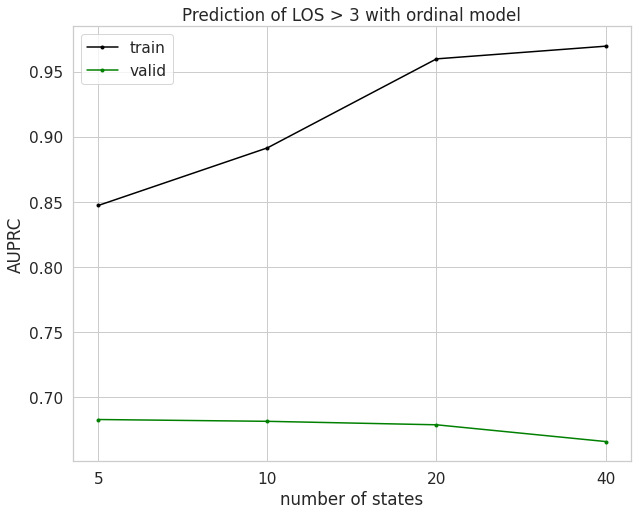

In [18]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(states_list), train_auprc_per_state_np, 'k.-', label='train')
axs.plot(np.array(states_list), val_auprc_per_state_np, 'g.-', label='valid')
# axs.plot(np.array(states_list), test_auprc_per_state_np, 'b.-', label='test')
axs.legend()
axs.set_ylabel('AUPRC')
axs.set_xlabel('number of states')
axs.set_title('Prediction of LOS > 3 with ordinal model')

## plot the performance as a function of penalty

In [19]:
# penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.1', '0.25', '0.5', '1', '5', '10']
penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.005', '0.1', '0.25', '0.5', '1', '5', '10']
test_perf_per_penalty = []
val_perf_per_penalty = []
train_perf_per_penalty = []
for pen in penalty_list:
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*predictor_l2_penalty=%s-*n_states=20*.csv'%pen))
    
    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    
    train_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]
        
        train_auprc_np_7[ii] = curr_perf_df['train_AUPRC_7'].values[-1]
        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind = np.argmax(valid_auprc_np_3)
    val_perf_per_penalty.append(valid_auprc_np_3[best_ind])
    test_perf_per_penalty.append(test_auprc_np_3[best_ind])
    train_perf_per_penalty.append(train_auprc_np_3[best_ind])

Text(0.5, 1.0, 'Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

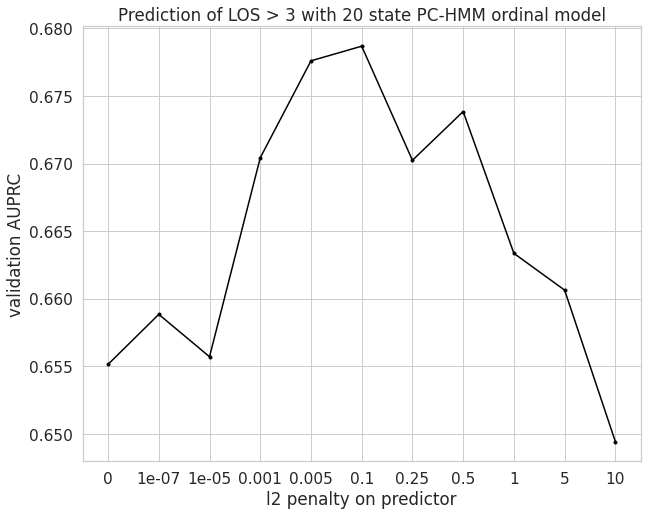

In [20]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(penalty_list), np.array(val_perf_per_penalty), 'k.-')
axs.set_ylabel('validation AUPRC')
axs.set_xlabel('l2 penalty on predictor')
axs.set_title('Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

In [45]:
test_perf_per_penalty

[0.5434338285561435, 0.5613730226929461]

## Plot the loss plots for the 20 state PC-HMM

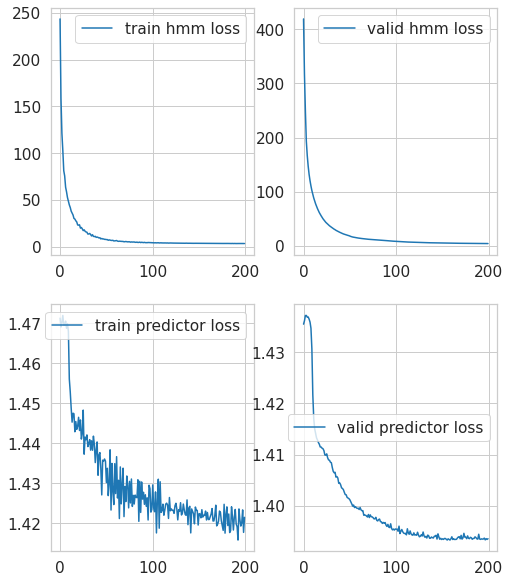

In [21]:
save_dir = "/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/"
hist_csv = os.path.join(save_dir, "semi-supervised-pchmm-lr=0.005-seed=194-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0.1-perc_labelled=100-n_states=20-lamb=100.csv")

f, axs = plt.subplots(2, 2, figsize=(8, 10))
axs_list = axs.flatten()
lamb = int(hist_csv.replace('.csv', '').split('lamb=')[-1])

final_hist_df = pd.read_csv(hist_csv)

epochs = range(len(final_hist_df))
train_hmm_loss = final_hist_df['hmm_model_loss'].values
val_hmm_loss = final_hist_df['val_hmm_model_loss'].values

train_predictor_loss = final_hist_df['predictor_loss'].values/lamb
val_predictor_loss = final_hist_df['val_predictor_loss'].values/lamb

axs_list[0].plot(epochs, train_hmm_loss, label='train hmm loss')
axs_list[1].plot(epochs, val_hmm_loss, label='valid hmm loss')

axs_list[2].plot(epochs, train_predictor_loss, label='train predictor loss')
axs_list[3].plot(epochs, val_predictor_loss, label='valid predictor loss')

for ax in axs_list:
    ax.legend()

In [6]:
446*3

1338